---
toc: false
page-layout: full
execute: 
  enabled: false
---

# Lecture 10A: From Notebooks to the Web: Panel

- Section 401
- Nov 6, 2023

In [19]:
import folium
import geopandas as gpd
import pandas as pd
import xyzservices

## Web-based Data Viz

Last week we discussed the final project as well as ways to translate our analysis results to the Web in a meaningful way. We'll cover two methods to do so, each with their own pros and cons:

**Last week**

1. Embedding interactive charts on the Web via Quarto & Github Pages

**This week**

2. Creating Web apps & dashboards using the Python library [Panel](https://panel.holoviz.org/)


## Panel: picking up where we left off


<a href="https://panel.pyviz.org/" ><img src="imgs/panel-logo.png" width=300></a>


The default panel import:

In [187]:
# Load panel and enable interactive features
import panel as pn

pn.extension("tabulator")

### Panel APIs: different ways to use Panel

There are three main ways (what they call APIs) to use Panel to create dashboards:

- **Interact functions:** Auto-generates a full UI (including widgets) given a function
- **Reactive functions:** Linking functions or methods to widgets using pn.bind or the equivalent pn.depends decorator, declaring that the function should be re-run when those widget values change
- **Parameterized classes:** Declare parameters and their ranges in Parameterized classes, then get GUIs (and value checking!) for free


**Reference:** See [the API section of the User Guide](https://panel.holoviz.org/explanation/api/index.html) for a more detailed discussion

### Quick API demo: the "cars" dataset

We'll demonstrate the three Panel APIs by creating the same, small dashboard using the "cars" example dataset. Then, we'll dive into more complex and realistic examples!  

In [2]:
import hvplot.pandas
from bokeh.sampledata.autompg import autompg  # cars dataset

In [3]:
autompg.head()

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
# Set up a function to plot using hvplot
def autompg_plot(x="mpg", y="hp", color="#058805"):
    return autompg.hvplot.scatter(x, y, c=color, padding=0.1)


# Get the columns to use
columns = list(autompg.columns[:-2])
columns

['mpg', 'cyl', 'displ', 'hp', 'weight', 'accel', 'yr']

### API Option #1. Interact Functions

The interact function will *magically* generate a UI (including widgets) automatically by inspecting the arguments of the function given to it.

In the case below, we give the `autompg_plot()` the allowed options for its 3 arguments `x`, `y`, and `color`, and it auto-generates a Panel dashboard.

In [5]:
# Create a widget to select the color of the scatter points
color = pn.widgets.ColorPicker(name="Color Selector", value="#4f4fdf")

# Auto-generate the layout
layout = pn.interact(autompg_plot, x=columns, y=columns, color=color)

# Optional: Customize the layout by creating the dashboard with a Row and Column
# interact_dashboard = pn.Row(pn.Column("## MPG Explorer", layout[0]), layout[1])
# interact_dashboard

layout

Column(sizing_mode='fixed')
    [0] Column
        [0] Select(name='x', options=['mpg', 'cyl', ...], value='mpg')
        [1] Select(name='y', options=['mpg', 'cyl', ...], value='hp')
        [2] ColorPicker(name='Color Selector', value='#4f4fdf')
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Scatter, height=300, name='interactive00806', sizing_mode='fixed', width=700)

For my taste, the *interact* API is a little *too* simple. I prefer to have more control over the dashboard. For that reason, I prefer to use the next two APIs the most often.

### API Option #2. Reactive Functions

- Very similar to the `interact` API but is more explicit about widget selection and layout.
- You must use the `pn.bind` function to select and configure widgets explicity and to lay out components explicitly.
- The `pn.bind()` function explicitly links the values of the widgets to the arguments of a function.

::: {.callout-note title="Find out more"}
For more info, see this discussion of the [pros and cons](https://panel.holoviz.org/explanation/api/reactive.html) of this approach.
:::

In [11]:
# Create the widgets
xSelect = pn.widgets.Select(value="mpg", options=columns, name="x")
ySelect = pn.widgets.Select(value="hp", options=columns, name="y")
colorPicker = pn.widgets.ColorPicker(name="Color", value="#AA0505")

# Create the dashboard
reactive_dashboard = pn.Row(
    # Left: the main chart, bind widgets to the function
    pn.bind(autompg_plot, x=xSelect, y=ySelect, color=colorPicker),
    # Right: the title and widgets stacked vertically
    pn.Column("## MPG Explorer", xSelect, ySelect, colorPicker),
)


reactive_dashboard

Row
    [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Column
        [0] Markdown(str)
        [1] Select(name='x', options=['mpg', 'cyl', ...], value='mpg')
        [2] Select(name='y', options=['mpg', 'cyl', ...], value='hp')
        [3] ColorPicker(name='Color', value='#AA0505')

### A more realistic example with the reactive API

Let's re-visit our trash-related 311 requests from [Lecture 4B](https://musa-550-fall-2023.github.io/content/week-4/lecture-4B.html).

In Lecture 4B, we used Folium plugins to explore the trends by neighborhood, focusing specifically on the Greenwich neighborhood. We can use Panel widgets to easily add a widget to explore different neighborhoods.

Let's use the `pn.bind()` function to build a Panel dashboard that adds a dropdown widget to select the neighborhood we want to explore.

First, let's load the dataset from a CSV file and convert to a GeoDataFrame:

In [107]:
# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-4/main/data/trash_311_requests_2020.csv"
)

# Remove rows with missing geometry
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])

# Create our GeoDataFrame with geometry column created from lon/lat
trash_requests = gpd.GeoDataFrame(
    trash_requests_df,
    geometry=gpd.points_from_xy(trash_requests_df["lon"], trash_requests_df["lat"]),
    crs="EPSG:4326",
)

In [108]:
trash_requests.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon,geometry
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518,POINT (-75.10652 40.03439)
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497,POINT (-75.16350 39.93616)
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345,POINT (-75.01835 40.05874)
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347,POINT (-75.02235 40.06366)
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732,POINT (-75.24473 39.95819)


Load neighborhoods and do the spatial join to associate a neighborhood with each ticket:

In [109]:
# Load the neighborhoods
neighborhoods = gpd.read_file(
    "https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-4/main/data/zillow_neighborhoods.geojson"
)

# Do the spatial join to add the "ZillowName" column
requests_with_hood = gpd.sjoin(
    trash_requests,
    neighborhoods.to_crs(trash_requests.crs), # REMEMBER: convert to the right CRS
    predicate="within",
)

In Lecture 4B, we explored trends in the Greenwich neighborhood of the city:

In [110]:
# Extract out the point tickets for Greenwich
greenwich_tickets = requests_with_hood.query("ZillowName == 'Greenwich'")

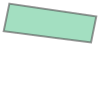

In [111]:
# Get the neighborhood boundary for Greenwich
greenwich_geo = neighborhoods.query("ZillowName == 'Greenwich'")

greenwich_geo.squeeze().geometry

Use the `explore()` function to create a Folium map of the tickets:

In [112]:
# Plot the neighborhood boundary
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)


# Add the individual tickets as circle markers and style them
greenwich_tickets.explore(
    m=m,  # Add to the existing map!
    marker_kwds={"radius": 7, "fill": True, "color": "crimson"},
    marker_type="circle_marker",  # or 'marker' or 'circle'
    name="Tickets",
)

m  # show map

#### Improvement #1: Add a neighborhood dropdown

Let's add our dropdown widget for neighborhood. We'll use a [Select widget](https://panel.holoviz.org/reference/widgets/Select.html).

First, we need to get a list of the unique neighborhood names we want to include as options.

In [113]:
neighborhood_names = list(neighborhoods['ZillowName'].unique())

neighborhood_names[:10]

['Academy Gardens',
 'Airport',
 'Allegheny West',
 'Andorra',
 'Aston Woodbridge',
 'Bartram Village',
 'Bella Vista',
 'Belmont',
 'Brewerytown',
 'Bridesburg']

Create the widget:

In [114]:
# Create the widget
neighborhoodSelect = pn.widgets.Select(
    value="Greenwich", options=neighborhood_names, name="Neighborhood"
)

neighborhoodSelect

Select(name='Neighborhood', options=['Academy Gardens', ...], value='Greenwich')

Now, let's set up our reactive "callback" function: this is the function that will be called every time the widget updates.

This function will do the following things. Provided with an input neighborhood name, it will:

1. Filter the tickets data for input neighborhood
1. Get the geometry for the neighborhood
1. Plot the geometry boundary and tickets on the same Folium map
1. Return a panel Folium "pane"

::: {.callout-note}
In the last step we return a [Folium pane](https://panel.holoviz.org/reference/panes/Folium.html). This is Panel's wrapper of a Folium map. Importantly, it let's us set the height of the Folium map in the dashboard!
:::

In [215]:
def filter_by_neighborhood(data, neighborhood_name):
    """
    Filter data by neighborhood.
    """

    sel = requests_with_hood["ZillowName"] == neighborhood_name
    return data.loc[sel]


def plot_ticket_data(data, neighborhood_name):
    """
    Plot the ticket data and neighborhood boundary on a Folium map.
    """

    # Get the neighborhood geometry
    sel = neighborhoods["ZillowName"] == neighborhood_name
    hood_geo = neighborhoods.loc[sel]

    # Plot the neighborhood boundary
    m = hood_geo.explore(
        style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
        name="Neighborhood boundary",
        tiles=xyzservices.providers.CartoDB.Voyager,
    )

    # Step 4: Overlay the individual tickets as circle markers and style them
    data.explore(
        m=m,  # Add to the existing map!
        marker_kwds={"radius": 7, "fill": True, "color": "crimson"},
        marker_type="circle_marker",  # or 'marker' or 'circle'
        name="Tickets",
    )

    return m

In [237]:
def create_dashboard_1(neighborhood_name):
    """
    Plot trash-related requests for the input neighborhood.
    """
    # Step 1: Filter the tickets data for input neighborhood
    tickets = filter_by_neighborhood(requests_with_hood, neighborhood_name)

    # Step 2: Make the Folium map
    m = plot_ticket_data(tickets, neighborhood_name)

    # Step 3: Return a Folium pane
    # IMPORTANT: set the height!
    return pn.pane.plot.Folium(m, height=600)

Let's layout out our dashboard:

In [240]:
# Create the dashboard
ticket_dashboard_1 = pn.Column(
    # Top: the title and dropdown widget
    pn.Column("## Trash-Related 311 Tickets by Neighborhood", neighborhoodSelect),
    # Add a height spacer
    pn.Spacer(height=25),
    # Bottom: the main chart, bind widgets to the function
    pn.bind(create_dashboard_1, neighborhood_name=neighborhoodSelect),
)


ticket_dashboard_1

Column
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Neighborhood', options=['Academy Gardens', ...], value='Ludlow')
    [1] Spacer(height=25)
    [2] ParamFunction(function, _pane=Folium, defer_load=False)

#### Improvement #2: Add a date range slider

Let's add a [datetime range slider widget](https://panel.holoviz.org/reference/widgets/DatetimeRangeSlider.html) that will allow us to show tickets for a particular date range.


The datetime slider widget expects "datetime" objects from the built-in datetime library. Let's import it first:

In [218]:
import datetime as dt

Our data is from 2020. So, let's set the default values: Jan 1, 2020 and Dec 31, 2020:

In [198]:
DEFAULT_START = dt.datetime(2020, 1, 1)
DEFAULT_END = dt.datetime(2020, 12, 31)

::: {.callout-note}
I've used upper case for these default variable names. That's a good notation to follow... it helps you easily separate out variables that are constant and unchanging when doing dashboard design!

:::

Now, initialize the datetime range slider.

Note that the value of the slider is a *tuple* of two values: `(start_date, end_date)`

In [201]:
datetime_range_slider = pn.widgets.DatetimeRangeSlider(
    name="Date Slider",
    start=DEFAULT_START,
    end=DEFAULT_END,
    value=(DEFAULT_START, DEFAULT_END),
    step=1000 * 60 * 60, # 1 hour in milliseconds
)

datetime_range_slider

DatetimeRangeSlider(end=datetime.datetime(2020, ..., name='Date Slider', start=datetime.datetime(2020, ..., step=3600000, value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2020, ..., value_start=datetime.datetime(2020, ...)

The value is a tuple of start and end dates:

In [203]:
datetime_range_slider.value

(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))

Let's also create a new neighborhood widget to avoid confusion across multiple dashboards:

In [205]:
# Create the widget
neighborhoodSelect_2 = pn.widgets.Select(
    value="Greenwich", options=neighborhood_names, name="Neighborhood"
)

Now, we'll define a new function that filters the data by neighborhood AND date range:

In [213]:
def filter_by_date(data, start_date, end_date):
    """
    Filter data by start and end date.
    """
    # Convert ticket column of strings to DateTime objects
    requested_dates = pd.to_datetime(data["requested_datetime"])

    ## Two selections
    sel_start = requested_dates >= start_date
    sel_end = requested_dates <= end_date

    ## Logical "and" for final selection
    date_sel = sel_start & sel_end

    ## Filter tickets by date range
    return data.loc[date_sel]

In [239]:
def create_dashboard_2(neighborhood_name, date_range):
    """
    Plot trash-related requests for the input neighborhood AND date range.
    """
    # Step 1: Filter the tickets data for input neighborhood
    tickets = filter_by_neighborhood(requests_with_hood, neighborhood_name)

    # NEW, Step 2: Do the selection by the input date
    tickets = filter_by_date(tickets, date_range[0], date_range[1])

    # Step 3: Make the Folium map
    m = plot_ticket_data(tickets, neighborhood_name)

    # Step 5: Return a Folium pane
    return pn.pane.plot.Folium(m, height=600)

In [241]:
# Create the dashboard
ticket_dashboard_2 = pn.Column(
    # Top: the title and dropdown widget
    pn.Column(
        "## Trash-Related 311 Tickets by Neighborhood",
        neighborhoodSelect_2,
        datetime_range_slider,
    ),
    # Add a height spacer
    pn.Spacer(height=25),
    # Bottom: the main chart, bind widgets to the function
    pn.bind(
        create_dashboard_2,
        neighborhood_name=neighborhoodSelect_2,
        date_range=datetime_range_slider,
    ),
)


ticket_dashboard_2

Column
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Neighborhood', options=['Academy Gardens', ...], value='Hartranft')
        [2] DatetimeRangeSlider(end=datetime.datetime(2020, ..., name='Date Slider', start=datetime.datetime(2020, ..., step=3600000, value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2020, ..., value_start=datetime.datetime(2020, ...)
    [1] Spacer(height=25)
    [2] ParamFunction(function, _pane=Folium, defer_load=False)

#### Improvement #3: Let's show the currently filtered data

We can use the [Tabulator widget](https://panel.holoviz.org/reference/widgets/Tabulator.html) to show the ticket data. Let's add the table below the map -- we can update our dashboard function to add it below the map in a panel Column!

Re-initialize our widgets to avoid confusion with multiple dashboards:

In [244]:
# Neighborhood select
neighborhoodSelect_3 = pn.widgets.Select(
    value="Greenwich", options=neighborhood_names, name="Neighborhood"
)

# Datetime slide
datetime_slider_3 = pn.widgets.DatetimeRangeSlider(
    name="Date Slider",
    start=DEFAULT_START,
    end=DEFAULT_END,
    value=(DEFAULT_START, DEFAULT_END),
    step=1000 * 60 * 60,  # 1 hour in milliseconds
)

In [242]:
def plot_ticket_data_3(neighborhood_name, date_range):
    """
    Plot trash-related requests for the input neighborhood AND date range.

    Output a Folium map and data table.
    """
    # Step 1: Filter the tickets data for input neighborhood
    tickets = filter_by_neighborhood(requests_with_hood, neighborhood_name)

    # Step 2: Do the selection by the input date
    tickets = filter_by_date(tickets, date_range[0], date_range[1])

    # Step 3: Make the Folium map
    m = plot_ticket_data(tickets, neighborhood_name)

    # Step 4: Ouput map and table
    return pn.Column(
        pn.pane.plot.Folium(m, height=600),
        pn.widgets.Tabulator(tickets, show_index=False, page_size=25),
    )

In [245]:
# Create the dashboard
ticket_dashboard_3 = pn.Column(
    # Top: the title and dropdown widget
    pn.Column(
        "## Trash-Related 311 Tickets by Neighborhood",
        neighborhoodSelect_3,
        datetime_slider_3,
    ),
    # Add a height spacer
    pn.Spacer(height=25),
    # Bottom: the main chart, bind widgets to the function
    pn.bind(
        plot_ticket_data_3,
        neighborhood_name=neighborhoodSelect_3,
        date_range=datetime_slider_3,
    ),
)


ticket_dashboard_3

Column
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Neighborhood', options=['Academy Gardens', ...], value='Greenwich')
        [2] DatetimeRangeSlider(end=datetime.datetime(2020, ..., name='Date Slider', start=datetime.datetime(2020, ..., step=3600000, value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2020, ..., value_start=datetime.datetime(2020, ...)
    [1] Spacer(height=25)
    [2] ParamFunction(function, _pane=Column, defer_load=False)

### The reactive API: takeaways

- Very powerful for exploratory analyses in a notebook
- Complex data wrangling can get complicated!
    - *For example*: what if we wanted to add another pane with another function to our previous dashboard? We would have to copy over the same filtering code to our new function -- no easy way to re-use the data selection steps we had in our first function.
    
**Takeaway**: It would be easier if we could *save* variables and repeat them across functions. This becomes possible if we use the third Panel API: parameterized classes!

### API Option #3. Parametrized Classes

You are welcome to use any of the APIs to create dashboards with Panel. However, this is my **recommended approach** when you are building more complex dashboards.

We'll define our app in a declarative fashion using a **custom Python class** that defines the various components of our dashboard, which include:

- The parameters we want the user to be able to change.
- *Reactive* functions to generate the various charts/maps in our dashboard, based on those input parameters.
- The dependencies between our chart functions and parameters.


**Note:** The example apps we'll talk about next lecture on our course Github page use the class API to define the dashboard.

::: {.callout-note title="Find out more"}
For more info, see this discussion of the [pros and cons](https://panel.holoviz.org/explanation/api/parameterized.html) of this approach.
:::

#### First some quick background: an introduction to Python classes

Let's take a quick look at [this nice tutorial](http://introtopython.org/classes.html)

Now, let's return to our "toy" example with the "cars" dataset:

In [254]:
import param

::: {.callout-important}
### Important: Parameter Types

See the [panel docs](https://panel.holoviz.org/how_to/param/uis.html) for a guide to generate widgets directly from parameters using the class API.
:::

In [255]:
# Define the class
class MPGExplorer(param.Parameterized):
    """A Panel dashboard class."""

    x = param.Selector(default="mpg", objects=columns)
    y = param.Selector(default="hp", objects=columns)
    color = param.Color(default="#0f0f0f")

    @param.depends("x", "y", "color")  # This is a Python "decorator"!
    def make_autompg_plot(self):
        return autompg_plot(self.x, self.y, self.color)

::: {.callout-tip}
For more info on decorators, check out [this DataCamp tutorial](https://www.datacamp.com/tutorial/decorators-python).
:::

In [256]:
# Initialize the dashboard class object
explorer = MPGExplorer()

# Create the dashboard layout
# Note: widgets are stored in the 'param' attribute by default
class_dashboard = pn.Row(explorer.param, explorer.make_autompg_plot)

class_dashboard

Row
    [0] Column(margin=(5, 10), name='MPGExplorer')
        [0] StaticText(value='<b>MPGExplorer</b>')
        [1] Select(name='X', options=OrderedDict([('mpg', ...]), value='mpg')
        [2] Select(name='Y', options=OrderedDict([('mpg', ...]), value='hp')
        [3] ColorPicker(name='Color', value='#0f0f0f')
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

Note that when we change the selections above, the attributes of the `explorer` object update:

In [257]:
explorer.x

'mpg'

In [258]:
explorer.y

'hp'

In [259]:
explorer.color

'#0f0f0f'

## To be continued!

Two examples of Panel dashboards using the classes API on Wednesday!